### For NN approach see: https://colab.research.google.com/drive/1pUG7F9IVwsM4Iwl2l9ag6VfO2I0oGylE?usp=sharing

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, ParameterGrid
from sklearn.metrics import (make_scorer, mean_absolute_error, mean_squared_error, 
                             balanced_accuracy_score, classification_report, confusion_matrix) 


In [90]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_report(y_true, y_pred):
    print("Test MSE: ", mean_squared_error(y_true, y_pred))
    print("Test MAE: ", mean_absolute_error(y_true, y_pred))

In [3]:
RS = 42

In [4]:
df_features = pd.read_csv("train_data.csv", index_col=0)
labels = pd.read_csv('../data/labels.csv', index_col=0)[['n_cited']]

df = labels.join(df_features)

In [5]:
df = df.iloc[1000:-100]

In [6]:
X, y = df.iloc[:, 1:].values, df.n_cited.values.reshape(-1, 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=RS)

In [8]:
y_train[y_train>20] = 20

In [9]:
gbm = lgb.LGBMRegressor(random_state=RS)
gbm.fit(X_train,y_train.ravel())

LGBMRegressor(random_state=42)

### Analysis of the feature importances

In [58]:
feature_imp = pd.DataFrame({'Value': gbm.feature_importances_, 'Feature': df.iloc[:, 1:].columns})

In [63]:
ner_imp = feature_imp.iloc[-256:].Value.sum()
ner_label = 'NER Vector'

In [64]:
feature_imp = feature_imp.iloc[:-256]

In [66]:
topics_imp = feature_imp.iloc[-128:].Value.sum()
topics_label = 'Topics Vector'

In [67]:
feature_imp = feature_imp.iloc[:-128]

In [69]:
doc_imp = feature_imp.iloc[-256:].Value.sum()
doc_label = 'Document Vector'

In [70]:
feature_imp = feature_imp.iloc[:-256]

In [80]:
ner_df = pd.DataFrame({'Value': ner_imp, "Feature": ner_label}, index=[0])
topics_df = pd.DataFrame({'Value': topics_imp, "Feature": topics_label}, index=[0])
doc_df = pd.DataFrame({'Value': doc_imp, "Feature": doc_label}, index=[0])

In [81]:
feature_imp = pd.concat([feature_imp, ner_df, topics_df, doc_df])

In [91]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

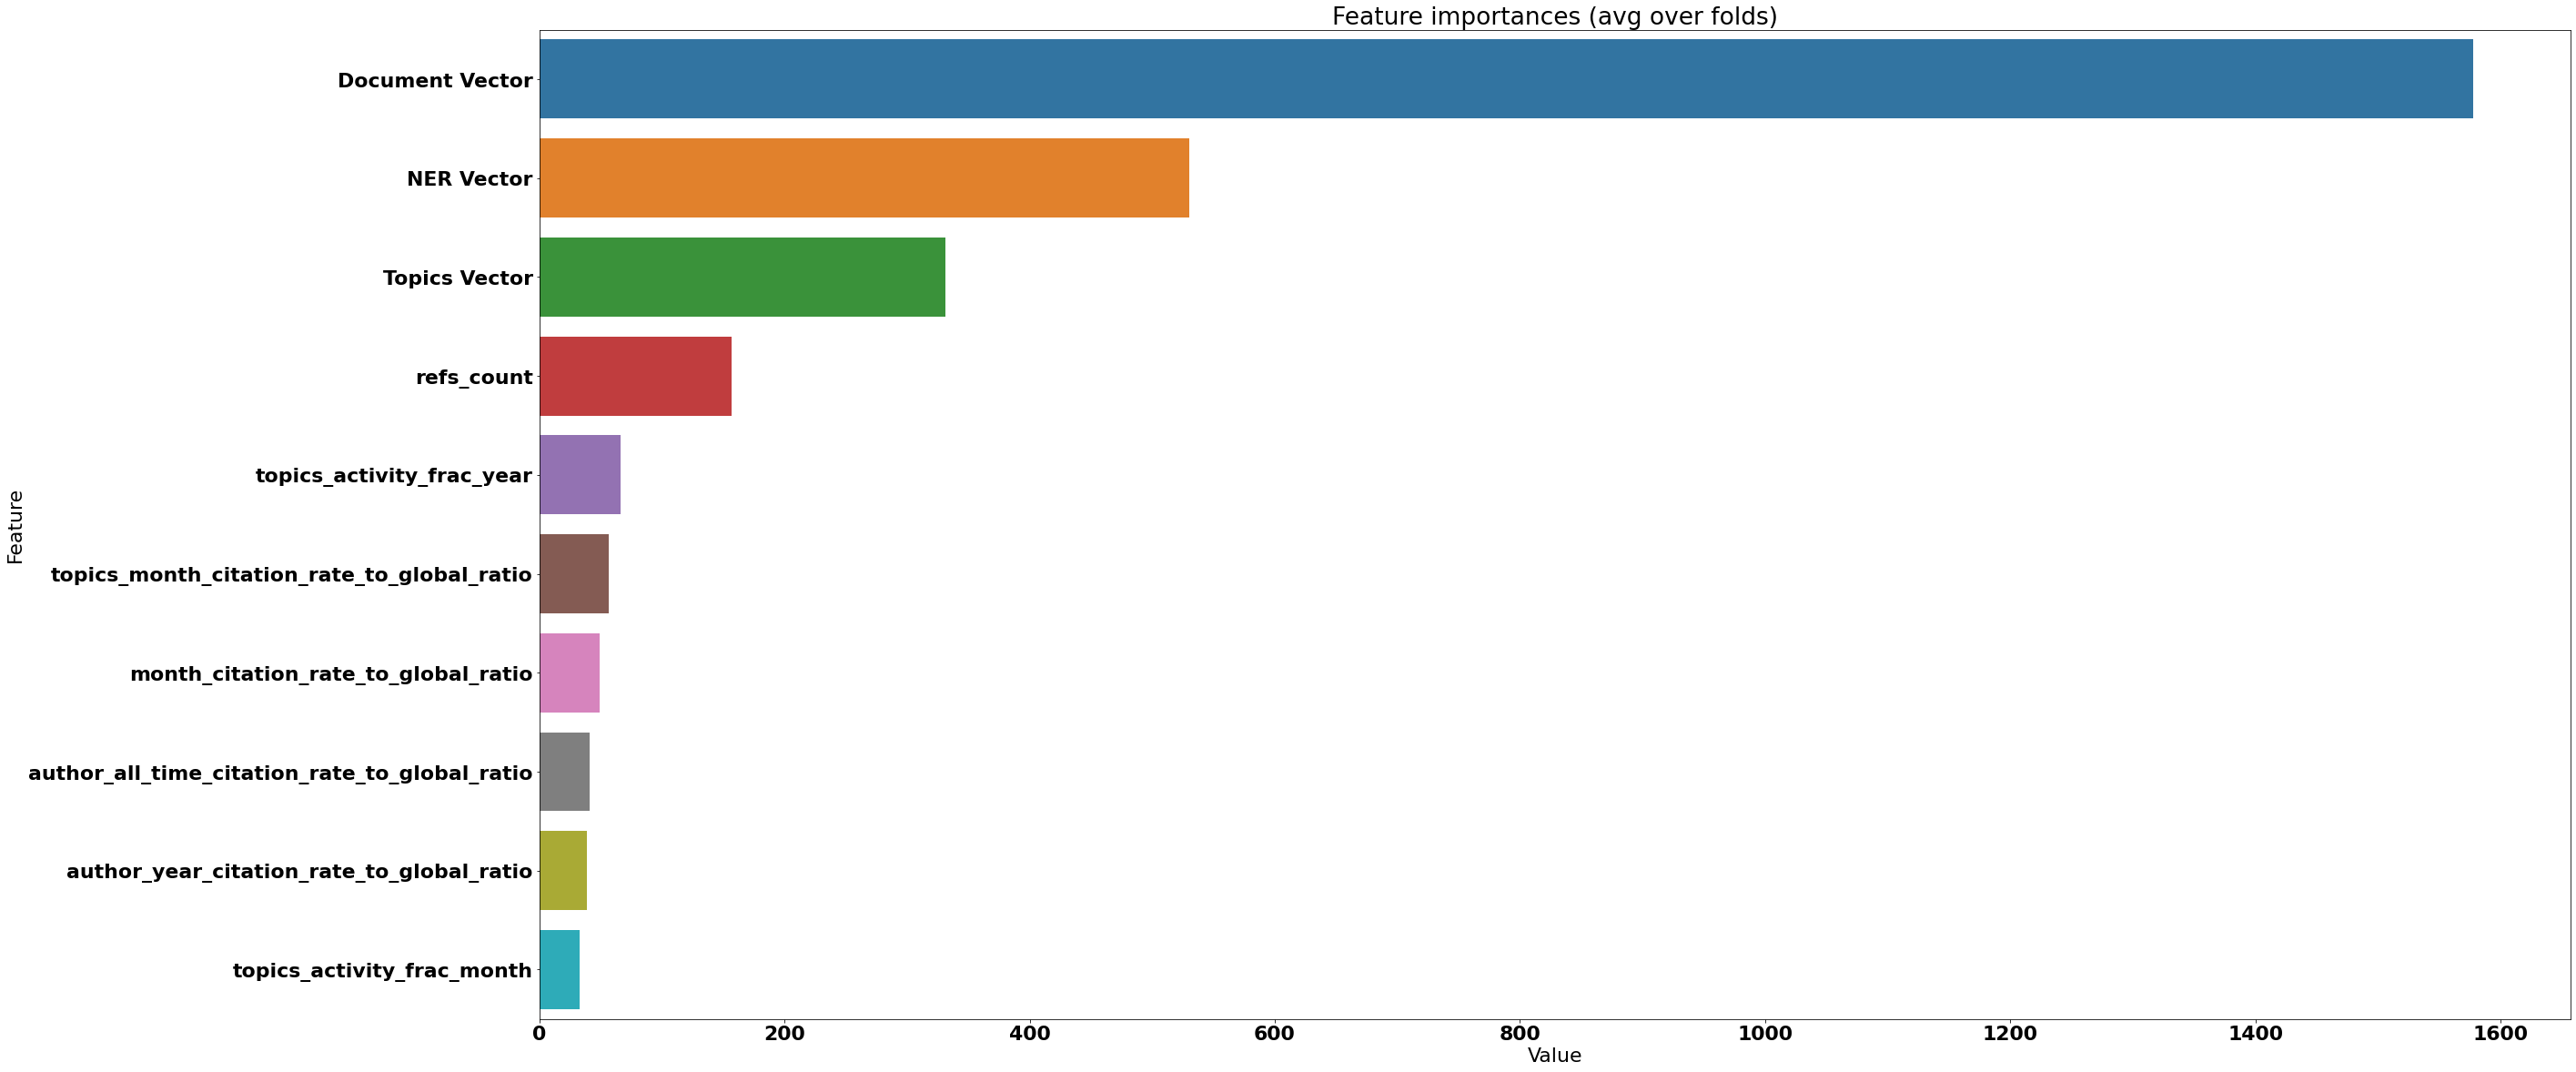

In [92]:
plt.figure(figsize=(40, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:10])
plt.title('Feature importances (avg over folds)')
plt.show()

In [11]:
y_pred = gbm.predict(X_test)
y_train_pred = gbm.predict(X_train)
print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train MAE: ", mean_absolute_error(y_train, y_train_pred))
get_report(y_test, y_pred)

Train MSE:  6.24455117713439
Train MAE:  1.5234714369414772
Test MSE:  34.076039046623116
Test MAE:  2.329900223363875


In [15]:
# rf = RandomForestRegressor(random_state=RS, n_estimators=200, max_depth=10)
# rf.fit(X_train, y_train.ravel())

In [16]:
# y_pred = rf.predict(X_test)
# y_train_pred = rf.predict(X_train)
# print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
# print("Train MAE: ", mean_absolute_error(y_train, y_train_pred))
# get_report(y_test, y_pred)

In [17]:
# feature_imp = pd.DataFrame({'Value': rf.feature_importances_, 'Feature': df.iloc[:, 1:].columns})

# plt.figure(figsize=(40, 20))
# sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
#                                                         ascending=False)[0:15])
# plt.title('RF Features (avg over folds)')
# plt.show()

### RF Regressor is very slow, will continue with LGBM

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=RS)
y_train[y_train>20] = 20

In [19]:
NFOLDS = 4
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=RS)

In [20]:
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [21]:
model = lgb.LGBMRegressor(random_state=RS)

In [28]:
parameters = {
    'n_estimators': [100, 250, 500, 750, 1000],
    'max_depth': [2, 4, 6, -1],
    'reg_alpha': [0.1, 1],
    'learning_rate': [0.001, 0.01, 0.1]
}

In [29]:
RSCV = RandomizedSearchCV(model, parameters, scoring=scorer, cv=kf, n_iter=333, verbose=3)

In [30]:
RSCV.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits
[CV 1/4] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=0.1;, score=-2.928 total time=   2.8s
[CV 2/4] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=0.1;, score=-2.952 total time=   2.9s
[CV 3/4] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=0.1;, score=-2.920 total time=   2.9s
[CV 4/4] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=0.1;, score=-2.892 total time=   2.8s
[CV 1/4] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=1;, score=-2.928 total time=   3.0s
[CV 2/4] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=1;, score=-2.952 total time=   3.2s
[CV 3/4] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=1;, score=-2.920 total time=   3.6s
[CV 4/4] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=1;, score=-2.892 total time=   2.9s
[CV 1/4] END learning_rate=0.001, max_dep

RandomizedSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=LGBMRegressor(random_state=42), n_iter=333,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [2, 4, 6, -1],
                                        'n_estimators': [100, 250, 500, 750,
                                                         1000],
                                        'reg_alpha': [0.1, 1]},
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False),
                   verbose=3)

In [31]:
best_estimator = RSCV.best_estimator_

In [32]:
y_pred = best_estimator.predict(X_test)  
y_train_pred = best_estimator.predict(X_train)
print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train MAE: ", mean_absolute_error(y_train, y_train_pred))
get_report(y_test, y_pred)

Train MSE:  2.0456382059095506
Train MAE:  0.9282602994649433
Test MSE:  32.84520666969111
Test MAE:  2.2802901033280283


In [33]:
RSCV.best_params_

{'reg_alpha': 1, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.1}

In [39]:
parameters = {
    'n_estimators': [100, 250, 500, 750, 1000],
    'max_depth': [2, 4, 6, 8, 10],
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [0.01, 0.1, 0.5],
    'learning_rate': [0.001, 0.01, 0.1]
}

In [40]:
model = lgb.LGBMRegressor(random_state=RS)

In [41]:
RSCV = RandomizedSearchCV(model, parameters, scoring=scorer, cv=kf, n_iter=333, verbose=3)

In [42]:
RSCV.fit(X_train, y_train)

Fitting 4 folds for each of 333 candidates, totalling 1332 fits
[CV 1/4] END learning_rate=0.01, max_depth=8, n_estimators=250, reg_alpha=0.5, reg_lambda=0.5;, score=-2.021 total time=  17.7s
[CV 2/4] END learning_rate=0.01, max_depth=8, n_estimators=250, reg_alpha=0.5, reg_lambda=0.5;, score=-2.051 total time=  17.1s
[CV 3/4] END learning_rate=0.01, max_depth=8, n_estimators=250, reg_alpha=0.5, reg_lambda=0.5;, score=-2.021 total time=  17.3s
[CV 4/4] END learning_rate=0.01, max_depth=8, n_estimators=250, reg_alpha=0.5, reg_lambda=0.5;, score=-1.994 total time=  16.6s
[CV 1/4] END learning_rate=0.01, max_depth=10, n_estimators=750, reg_alpha=0.5, reg_lambda=0.1;, score=-1.858 total time=  44.2s
[CV 2/4] END learning_rate=0.01, max_depth=10, n_estimators=750, reg_alpha=0.5, reg_lambda=0.1;, score=-1.884 total time=  45.0s
[CV 3/4] END learning_rate=0.01, max_depth=10, n_estimators=750, reg_alpha=0.5, reg_lambda=0.1;, score=-1.867 total time=  44.3s
[CV 4/4] END learning_rate=0.01, max_

RandomizedSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=LGBMRegressor(random_state=42), n_iter=333,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [2, 4, 6, 8, 10],
                                        'n_estimators': [100, 250, 500, 750,
                                                         1000],
                                        'reg_alpha': [0.1, 0.5, 1],
                                        'reg_lambda': [0.01, 0.1, 0.5]},
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False),
                   verbose=3)

In [43]:
best_estimator = RSCV.best_estimator_

In [55]:
y_pred = best_estimator.predict(X_test)
y_train_pred = best_estimator.predict(X_train)
print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train MAE: ", mean_absolute_error(y_train, y_train_pred))
get_report(y_test, y_pred)

Train MSE:  4.092746900390454
Train MAE:  1.2525450742994642
Test MSE:  33.33237488710514
Test MAE:  2.2991014013536173


In [56]:
RSCV.best_params_

{'reg_lambda': 0.5,
 'reg_alpha': 0.5,
 'n_estimators': 250,
 'max_depth': 8,
 'learning_rate': 0.1}

In [57]:
y_pred = best_estimator.predict(X_test).astype(int)
y_train_pred = best_estimator.predict(X_train).astype(int)
print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train MAE: ", mean_absolute_error(y_train, y_train_pred))
get_report(y_test, y_pred)

Train MSE:  4.337289910727645
Train MAE:  1.1113660166575232
Test MSE:  34.0261410202063
Test MAE:  2.1366398191324008
